# Defining urban census tracts
This script identifies tracts that are urbanized and within a core-based statistical area (as of 2020). It uses data including Census TIGER/Line boundaries for census tracts, urban areas, and core-based statistical areas, as well locale classifications from the National Center for Educational Statistics.

In [127]:
import geopandas
import ipumspy
import requests
import zipfile
import io
import os
import numpy
from ipumspy import IpumsApiClient, NhgisDataset, NhgisDatasetMetadata

### Identifying urban tracts on 2020 boundaries
This script draws on four boundary line data sources. 
- National Historic GIS 2020 census tract boundaries
- Census TIGER/Line files for 2020 Core-Based Statistical Areas (CBSAs)
- Census TIGER/Line files for 2020 Urban Areas 
- National Center for Education Statistics 2020 Locale Classifications

#### Tract boundaries
Start by pulling census tract boundaries from National Historical GIS. This requires a custom workflow based on the IPUMS API. To replicate, [create an NGHIS account](https://uma.pop.umn.edu/nhgis/user/new) and [register for an IPUMS API key](https://developer.ipums.org/docs/v2/get-started/). After querying the API and unpacking the nested file structure that it uses, load the boundaries as a geographic data frame with `geopandas`. 

In [2]:
# set IPUMS API key
ipums = IpumsApiClient("your key here")

In [55]:
# define the extract
extract = ipumspy.AggregateDataExtract(collection="nhgis",shapefiles=["us_tract_2020_tl2020"]) 

# submit API request
response = ipums.submit_extract(extract)
print(f"Submitted request 0{extract.extract_id} for shapefile {shapename}")

In [58]:
# download the extract
ipums.download_extract(response)
print(f"Downloaded request 0{extract.extract_id}")

Downloaded request 0278


In [60]:
# first level of unzipping
outer_zip = f"nhgis0{extract.extract_id}_shape.zip"
outer_dir = outer_zip.replace(".zip", "")
with zipfile.ZipFile(outer_zip, "r") as z:
    z.extractall(outer_dir)
print(f"{outer_zip} extracted to {outer_dir}")

nhgis0278_shape.zip extracted to nhgis0278_shape


<Axes: >

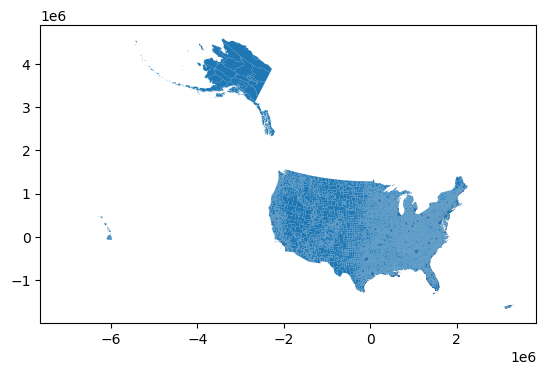

In [83]:
# load the spatial data
inner_zip = f"{outer_dir}/{outer_dir}/nhgis0{extract.extract_id}_shapefile_tl2020_us_tract_2020.zip"
tracts = geopandas.read_file(f"zip://{inner_zip}!/US_tract_2020.shp")
tracts = tracts.to_crs("ESRI:102003")
tracts.info()

#### Other geographies
The other spatial data layers are publicaly available via URLs. These can be downloaded directly, and then loaded as geographic data frames using `geopandas`.

<Axes: >

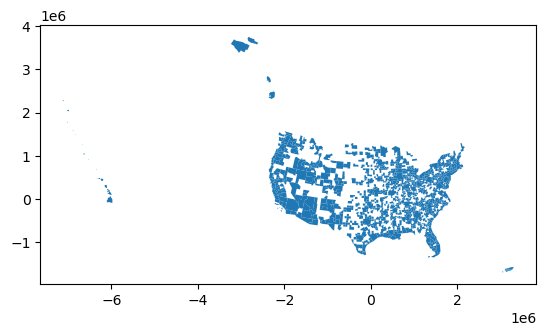

In [81]:
# load core-based statistical areas
## download the data
url = "https://www2.census.gov/geo/tiger/TIGER2020/CBSA/tl_2020_us_cbsa.zip"
response = requests.get(url)
with zipfile.ZipFile(io.BytesIO(response.content)) as zip:
    zip.extractall("cbsa_boundaries")

# read into a spatial data frame
cbsas = geopandas.read_file("cbsa_boundaries/tl_2020_us_cbsa.shp")
cbsas = cbsas.to_crs("ESRI:102003")
cbsas.plot()

#### Other geographies
The other source layers are available via URLS. These can be downloaded directly and then loaded as geographic data frames using `geopandas`. 

<Axes: >

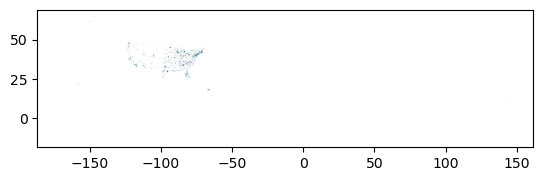

In [82]:
# load urban areas
## download the data
url = "https://www2.census.gov/geo/tiger/TIGER2020/UAC/tl_2020_us_uac20.zip"
response = requests.get(url)
with zipfile.ZipFile(io.BytesIO(response.content)) as zip:
    zip.extractall("urbanarea_boundaries")

# read into a spatial data frame
urban_areas = geopandas.read_file("urbanarea_boundaries/tl_2020_us_uac20.shp")
urban_areas = urban_areas.to_crs("ESRI:102003")
urban_areas.plot()

In [125]:
# load locale data -- Warning: It's a big file. This will take some time. 
## download the data
url = "https://nces.ed.gov/programs/edge/data/edge_locale20_nces_all_us.zip"
response = requests.get(url)
with zipfile.ZipFile(io.BytesIO(response.content)) as zip:
    zip.extractall("locale_boundaries")

# read into a spatial data frame
locales = geopandas.read_file("locale_boundaries/edge_locale20_nces_all_us.shp")
locales = locales.to_crs("ESRI:102003")
locales.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 564 entries, 0 to 563
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   LOCALE    564 non-null    object  
 1   STATEFP   564 non-null    object  
 2   GEO_YEAR  564 non-null    object  
 3   geometry  564 non-null    geometry
dtypes: geometry(1), object(3)
memory usage: 17.8+ KB


# Geoprocessing
The workflow then identifies urban census tracts within CBSAs. After that, it curates a relevant list of geographic identifiers for the tracts using spatial joins. 

In [105]:
# create centroids for each tract
## create centroid
tract_centroids = tracts.copy()
tract_centroids["geometry"] = tracts.centroid

## select tract variables
variables = ["GISJOIN", "GEOID", "STATEFP", "COUNTYFP", "TRACTCE"]
tract_centroids = tract_centroids[variables + ["geometry"]]

## drop tracts in Puerto Rico
tract_centroids = tract_centroids[~tract_centroids["GEOID"].str.startswith("72")]

tract_centroids.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 84121 entries, 0 to 84120
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   GISJOIN   84121 non-null  object  
 1   GEOID     84121 non-null  object  
 2   STATEFP   84121 non-null  object  
 3   COUNTYFP  84121 non-null  object  
 4   TRACTCE   84121 non-null  object  
 5   geometry  84121 non-null  geometry
dtypes: geometry(1), object(5)
memory usage: 4.5+ MB


In [106]:
# find centroids within CBSAs
tract_centroids = geopandas.clip(tract_centroids, cbsas)
tract_centroids.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 78136 entries, 71059 to 1527
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   GISJOIN   78136 non-null  object  
 1   GEOID     78136 non-null  object  
 2   STATEFP   78136 non-null  object  
 3   COUNTYFP  78136 non-null  object  
 4   TRACTCE   78136 non-null  object  
 5   geometry  78136 non-null  geometry
dtypes: geometry(1), object(5)
memory usage: 4.2+ MB


In [107]:
# and within urban areas
tract_centroids = geopandas.clip(tract_centroids, urban_areas)
tract_centroids.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 56886 entries, 71044 to 1520
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   GISJOIN   56886 non-null  object  
 1   GEOID     56886 non-null  object  
 2   STATEFP   56886 non-null  object  
 3   COUNTYFP  56886 non-null  object  
 4   TRACTCE   56886 non-null  object  
 5   geometry  56886 non-null  geometry
dtypes: geometry(1), object(5)
memory usage: 3.0+ MB


Now do some spatial joining to gather geography variables for each tract. 

In [119]:
# add CBSA indicators to the tracts
variables = ["CBSAFP", "NAME", "NAMELSAD"]
cbsas = cbsas[variables + ["geometry"]]
cbsas = cbsas.rename(columns = {
    "CBSAFP": "CBSAFP",
    "NAME": "CBSA_NAME",
    "NAMELSAD": "CBSA_NAMELSAD"
})

# spatial join tracts to CBSAs
tract_centroids = geopandas.sjoin(
    left_df = tract_centroids,
    right_df = cbsas,
    how = "left",
    predicate = "within"
).drop(columns=["index_right"])

tract_centroids.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 56886 entries, 71044 to 1520
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   GISJOIN        56886 non-null  object  
 1   GEOID          56886 non-null  object  
 2   STATEFP        56886 non-null  object  
 3   COUNTYFP       56886 non-null  object  
 4   TRACTCE        56886 non-null  object  
 5   geometry       56886 non-null  geometry
 6   CBSAFP         56886 non-null  object  
 7   CBSA_NAME      56886 non-null  object  
 8   CBSA_NAMELSAD  56886 non-null  object  
dtypes: geometry(1), object(8)
memory usage: 4.3+ MB


In [122]:
# add urban indicators to the tracts
variables = ["UACE20", "NAME20", "NAMELSAD20"]
urban_areas = urban_areas[variables + ["geometry"]]
urban_areas = urban_areas.rename(columns = {
    "UACE20": "UAFP",
    "NAME20": "UA_NAME",
    "NAMELSAD20": "UA_NAMELSAD"
})

# spatial join tracts to urban areas
tract_centroids = geopandas.sjoin(
    left_df = tract_centroids,
    right_df = urban_areas,
    how = "left",
    predicate = "within"
).drop(columns=["index_right"])

tract_centroids.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 56886 entries, 71044 to 1520
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   GISJOIN        56886 non-null  object  
 1   GEOID          56886 non-null  object  
 2   STATEFP        56886 non-null  object  
 3   COUNTYFP       56886 non-null  object  
 4   TRACTCE        56886 non-null  object  
 5   geometry       56886 non-null  geometry
 6   CBSAFP         56886 non-null  object  
 7   CBSA_NAME      56886 non-null  object  
 8   CBSA_NAMELSAD  56886 non-null  object  
 9   UAFP           56886 non-null  object  
 10  UA_NAME        56886 non-null  object  
 11  UA_NAMELSAD    56886 non-null  object  
dtypes: geometry(1), object(11)
memory usage: 5.6+ MB


In [132]:
tract_centroids = tract_centroids.drop(columns=["LOCALE", "LocaleType"])
tract_centroids.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 56886 entries, 71044 to 1520
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   GISJOIN        56886 non-null  object  
 1   GEOID          56886 non-null  object  
 2   STATEFP        56886 non-null  object  
 3   COUNTYFP       56886 non-null  object  
 4   TRACTCE        56886 non-null  object  
 5   geometry       56886 non-null  geometry
 6   CBSAFP         56886 non-null  object  
 7   CBSA_NAME      56886 non-null  object  
 8   CBSA_NAMELSAD  56886 non-null  object  
 9   UAFP           56886 non-null  object  
 10  UA_NAME        56886 non-null  object  
 11  UA_NAMELSAD    56886 non-null  object  
dtypes: geometry(1), object(11)
memory usage: 5.6+ MB


In [133]:
# add locale type to the tracts
variables = ["LOCALE"]
locales = locales[variables + ["geometry"]]

# spatial join tracts to urban areas
tract_centroids = geopandas.sjoin_nearest(
    left_df = tract_centroids,
    right_df = locales,
    how = "left"
).drop(columns=["index_right"])

tract_centroids.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 56886 entries, 71044 to 1520
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   GISJOIN        56886 non-null  object  
 1   GEOID          56886 non-null  object  
 2   STATEFP        56886 non-null  object  
 3   COUNTYFP       56886 non-null  object  
 4   TRACTCE        56886 non-null  object  
 5   geometry       56886 non-null  geometry
 6   CBSAFP         56886 non-null  object  
 7   CBSA_NAME      56886 non-null  object  
 8   CBSA_NAMELSAD  56886 non-null  object  
 9   UAFP           56886 non-null  object  
 10  UA_NAME        56886 non-null  object  
 11  UA_NAMELSAD    56886 non-null  object  
 12  LOCALE         56886 non-null  object  
dtypes: geometry(1), object(12)
memory usage: 6.1+ MB


In [134]:
# add a descriptive label for locale type
# Define the conditions 
conditions = [
    tract_centroids["LOCALE"].isin(["11", "12", "13"]),
    tract_centroids["LOCALE"].isin(["21", "22", "23"]),
    tract_centroids["LOCALE"].isin(["32", "33", "42", "43"]),
    tract_centroids["LOCALE"].isin(["31", "41"])
]

# list the corresponding outputs
choices = ["City", "Suburb", "Exurb", "Rural"]

# create the new column
tract_centroids["LocaleType"] = numpy.select(conditions, choices, default=None)

print(tract_centroids["LocaleType"].value_counts())

LocaleType
City      26715
Suburb    25670
Rural      2257
Exurb      2244
Name: count, dtype: int64


# Finishing up
Finally, we'll join the centroid layer back to the original tract polygons. After that, we'll save the boundaries to a `.gpkg` spatial database. 

In [136]:
# join back to the original tract boundaries
tracts = tracts[tracts["GISJOIN"].isin(tract_centroids["GISJOIN"])]
tracts

,GISJOIN,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,Shape_Leng,Shape_Area,geometry
0,G0100010020100,01,001,020100,01001020100,201,Census Tract 201,G5020,S,9825304.0,28435.0,+32.4819731,-086.4915648,16217.763443,9.853735e+06,"POLYGON ((888437.995 -515917.537, 888435.804 -..."
1,G0100010020200,01,001,020200,01001020200,202,Census Tract 202,G5020,S,3320818.0,5669.0,+32.4757580,-086.4724678,9824.372415,3.326483e+06,"POLYGON ((889844.072 -519142.061, 889844.876 -..."
2,G0100010020300,01,001,020300,01001020300,203,Census Tract 203,G5020,S,5349271.0,9054.0,+32.4740243,-086.4597033,10519.641206,5.358327e+06,"POLYGON ((891383.841 -518871.184, 891367.251 -..."
3,G0100010020400,01,001,020400,01001020400,204,Census Tract 204,G5020,S,6384282.0,8408.0,+32.4710304,-086.4448353,12521.196228,6.392683e+06,"POLYGON ((892527.268 -516528.67, 892531.715 -5..."
4,G0100010020501,01,001,020501,01001020501,205.01,Census Tract 205.01,G5020,S,6203654.0,0.0,+32.4478607,-086.4225578,11422.446991,6.203654e+06,"POLYGON ((895018.44 -518564.833, 895058.489 -5..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84082,G5600330000300,56,033,000300,56033000300,3,Census Tract 3,G5020,S,4404201.0,0.0,+44.8014066,-106.9641405,12417.906612,4.404204e+06,"POLYGON ((-861783.82 866846.559, -861807.923 8..."
84083,G5600330000400,56,033,000400,56033000400,4,Census Tract 4,G5020,S,6195244.0,11045.0,+44.8146370,-106.9617626,12828.681932,6.206292e+06,"POLYGON ((-861966.791 868735.883, -861927.21 8..."
84092,G5600370970602,56,037,970602,56037970602,9706.02,Census Tract 9706.02,G5020,S,1497769.0,0.0,+41.4973671,-109.4560495,5059.456175,1.497767e+06,"POLYGON ((-1111470.481 525989.18, -1111493.534..."
84096,G5600370970903,56,037,970903,56037970903,9709.03,Census Tract 9709.03,G5020,S,12277860.0,0.0,+41.5747069,-109.2595689,22035.877087,1.227786e+07,"POLYGON ((-1090776.18 534547.498, -1090801.149..."


In [139]:
# save to geopackage
tracts.to_file(
    filename = "tract_boundaries.gpkg",
    layer = "metrotracts_2020tr",
    driver = "GPKG"
)
print("Saved successfully")

Saved successfully
